# Gelogical Image Similarity
**This is a personal ML project on [Geological Image Similarity Dataset](https://www.kaggle.com/tanyadayanand/geological-image-similarity)**  

### BACKGROUND
A geology research company wants to create a tool for identifying interesting patterns in their imagery data. This tool
will possess a search capability whereby an analyst provides an image of interest and is presented with other images
which are similar to it.

### GOAL
Task is to create the machine learning component for this image similarity application. The machine learning
model should return the top K images that are most similar to this image based on a single image input.

### ABOUT the DATA:
The data includes 6 different classes of 5000 28X28 RGB images (total of 29998 images)

In [18]:
# Load usefull libraries and helper functions
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import random

from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.metrics.pairwise import cosine_similarity

## Load Files

In [19]:
# Initial files are in r'input\raw' directory
root_dir = 'kaggle/input'

# Get all filenames in folder: 
img_files = [os.path.join(path, name) for path, subdirs, files in os.walk(root_dir) for name in files]
print('dataset length = ', len(img_files))
print()

print('First 5 file names:', img_files[0:5])
print()

# Dataset consists of 6 folders each containing around 5k photographs
subfolders = [f.path for f in os.scandir(root_dir) if f.is_dir()]
for subfolder in subfolders:
    print(subfolder.split('\\')[-1], ':', len(os.listdir(subfolder)), 'images')

dataset length =  29998

First 5 file names: ['kaggle/input\\andesite\\012L6.jpg', 'kaggle/input\\andesite\\01ITR.jpg', 'kaggle/input\\andesite\\01LQQ.jpg', 'kaggle/input\\andesite\\0230P.jpg', 'kaggle/input\\andesite\\02741.jpg']

andesite : 5000 images
gneiss : 5000 images
marble : 4998 images
quartzite : 5000 images
rhyolite : 5000 images
schist : 5000 images


## Create Train-Test Split

## Preview the Images

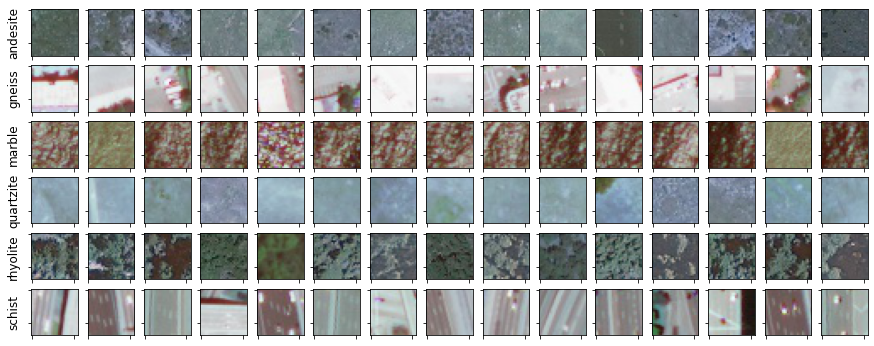

In [20]:
# Let's preview some randomly selected images of each class
n_show = 15

subfolders = [f.path for f in os.scandir(root_dir) if f.is_dir()]

fig, axes = plt.subplots(len(subfolders), n_show, figsize = (n_show,6))
# Preview images:
for row_idx, subfolder in enumerate(subfolders):    
    filenames = [f.path for f in os.scandir(subfolder)]   
    files_to_preview = random.sample(filenames, n_show)
    for col_idx, path in enumerate(files_to_preview):
        image = mpimg.imread(path)
        axes[row_idx, col_idx].imshow(image)
        axes[row_idx, col_idx].set_xticklabels([])
        axes[row_idx, col_idx].set_yticklabels([])

# Set labels:
for ax, row in zip(axes[:,0], subfolders):
    ax.set_ylabel(row.split('\\')[-1], rotation=90, size='large')

plt.show()

## Create PyTorch Dataset from the Data

In [21]:
# Let's transform our dataset to torch datasets:

class GeologicalDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, transform=None, train=True):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        
        img_names_list = [os.path.join(path, name) for path, subdirs, files in os.walk(root_dir) for name in files]
        label_to_idx = {
            'andesite': 0,
            'gneiss': 1,
            'marble': 2,
            'quartzite': 3,
            'rhyolite': 4,
            'schist': 5
            }
        labels_list = [label_to_idx[os.path.join(path, name).split('\\')[-2]]
                       for path, subdirs, files in os.walk(root_dir)
                       for name in files
                      ]
        
        img_names_train, img_names_test, labels_train, labels_test = train_test_split(
            img_names_list,
            labels_list,
            test_size=0.1,
            shuffle=True,
            random_state=42
        )

        if self.train == True:
            self.img_names = img_names_train
            self.labels = labels_train
        else:
            self.img_names = img_names_test
            self.labels = labels_test
            
    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):        
        image = mpimg.imread(self.img_names[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)

        return image, label

## Create Transforms for Train and Test

In [22]:
# Create transforms for train and test
    # All data transformed to Tensor and Normalized (for each channel) - see the parameters in the next cell
    # random horizontal and vertical flips used for train

train_transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    #transforms.RandomRotation(degrees=(0,360)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5080, 0.5196, 0.5195],
                         std=[0.1852, 0.1995, 0.2193])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5082, 0.5199, 0.5199],
                         std=[0.1849, 0.1993, 0.2192])
])

train_set = GeologicalDataset(root_dir = root_dir,transform=train_transform, train = True)

test_set = GeologicalDataset(root_dir = root_dir,transform=test_transform, train = False)


print('train_set:', len(train_set))
print('test_set:', len(test_set))

batch_size = 1024

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

train_set: 26998
test_set: 3000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 28, 28])


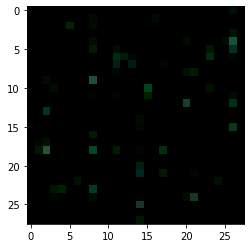

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
torch.Size([3, 28, 28])


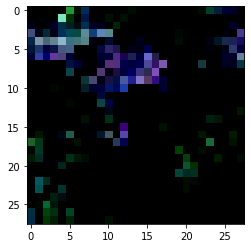

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4
torch.Size([3, 28, 28])


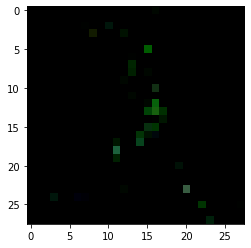

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4
torch.Size([3, 28, 28])


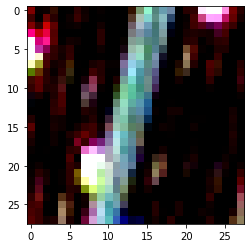

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5
torch.Size([3, 28, 28])


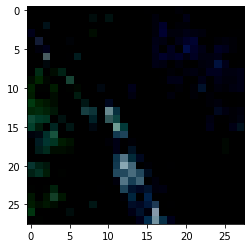

0
torch.Size([3, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


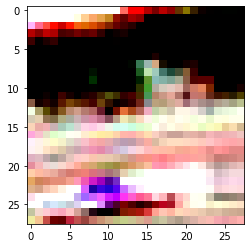

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1
torch.Size([3, 28, 28])


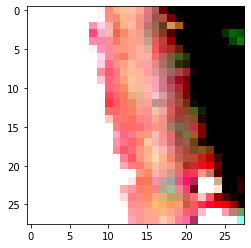

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1
torch.Size([3, 28, 28])


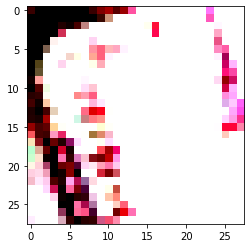

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1
torch.Size([3, 28, 28])


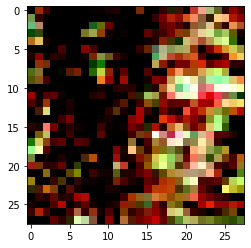

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
torch.Size([3, 28, 28])


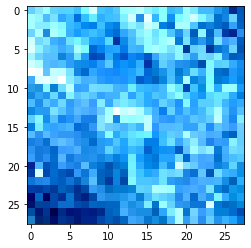

3


In [23]:
# Preview some images in the transformed form from the loader
for idx, (image, label) in enumerate(test_set):
    if idx == 10:
        break
    else:
        print(image.shape)
        plt.imshow(image.permute(1, 2, 0))
        plt.show()
        print(label)

## Create CNN Architecture
### Output for the penultimate layer (embedding) is also provided as output
![figure](figures\CNN.png "CNN")

In [24]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.nn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(in_features=2304, out_features=512),
            nn.Dropout2d(0.25),
            nn.Linear(in_features=512, out_features=128),
            )

        self.linear = nn.Linear(in_features=128, out_features=6)
        
    def forward(self, x):
        embedding = self.nn(x)
        x = self.linear(embedding)
        return embedding, x
        
#model = CNN()
#print(model)

## Instantiate the Model

In [25]:
model = CNN()

loss_func = nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train

In [26]:
def train(model, num_epochs, save_model=True):
    writer = SummaryWriter()
    
    for epoch in range(num_epochs):
        model.train()
        print('epoch:', epoch)
        
        train_accuracy_list=[]
        for batch, (images, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            _, outputs = model(images)
            predictions = torch.max(outputs, 1)[1]
            loss = loss_func(outputs, labels)
            print(loss)
            loss.backward()        
            optimizer.step()
            
            #train_accuracy = accuracy_score(predictions, labels)            
            #print('batch:', batch, '  train accuracy:', train_accuracy, 'loss', loss)
            #train_accuracy_list.append(train_accuracy)
        
        # At the end of epoch - evaluate test set accuracy
        test_accuracy_list=[]
        for batch, (images, labels) in enumerate(test_loader):
            model.eval()
            _, outputs = model(images)
            predictions = torch.max(outputs, 1)[1]
            test_accuracy = accuracy_score(predictions, labels)
            test_accuracy_list.append(test_accuracy)
        
        #avg_train_accuracy = np.mean(train_accuracy_list)
        #avg_test_accuracy = np.mean(test_accuracy_list)
        #writer.add_scalar("Accuracy_train", avg_train_accuracy, epoch)
        #writer.add_scalar("Accuracy_test", avg_test_accuracy, epoch)
        
        #print('Epoch: ', epoch, '  Train accuracy:', avg_train_accuracy, '  Test accuracy:', avg_test_accuracy, 'loss', loss)
    
    #writer.flush()

    if save_model==True:
        torch.save(model.state_dict(), 'model_state_dict.pth')

In [27]:
#tensorboard --logdir=runs

In [28]:
model=CNN()
# model = torch.load('model_state_dict.pth')
train(model, num_epochs=1)

epoch: 0
tensor(1.8280, grad_fn=<NllLossBackward>)
tensor(1.8162, grad_fn=<NllLossBackward>)
tensor(1.8245, grad_fn=<NllLossBackward>)
tensor(1.8242, grad_fn=<NllLossBackward>)
tensor(1.8292, grad_fn=<NllLossBackward>)
tensor(1.8196, grad_fn=<NllLossBackward>)
tensor(1.8395, grad_fn=<NllLossBackward>)
tensor(1.8248, grad_fn=<NllLossBackward>)
tensor(1.8231, grad_fn=<NllLossBackward>)
tensor(1.8149, grad_fn=<NllLossBackward>)
tensor(1.8285, grad_fn=<NllLossBackward>)


KeyboardInterrupt: 

In [ ]:
    #Plot Train and Test Accuracy Results
    plt.rcParams["figure.figsize"] = (10,10)
    plt.plot(list(range(len(train_accuracy_list))), train_accuracy_list, 'b', label='train')
    plt.plot((np.array(list(range(len(test_accuracy_list))))+1)*27, test_accuracy_list, '--ro', label='test')
    plt.ylim([0.9,1])
    plt.xlabel('batch #')
    plt.legend()
    plt.show()

## Embeddings

In [15]:
def get_embedding(file, model):
    image = mpimg.imread(file)
    image = test_transform(image)
    image = image.unsqueeze(0)
    model.eval()
    with torch.no_grad():
        emb, _ = model(image)
    return emb.numpy()

## Calculate Embeddings for Train Images

In [ ]:
train_loader_single = torch.utils.data.DataLoader(train_set, batch_size=1)
for images, labels in train_loader:
    _, outputs = model(images)

In [11]:
%%time
# Get embeddings for train data

    
train_dir = 'input\\train'
img_files_train = [os.path.join(path, name) for path, subdirs, files in os.walk(train_dir) for name in files]

train_emb = np.zeros((len(img_files_train), 128))
for idx, file in enumerate(img_files_train):
    train_emb[idx] = get_embedding(file, model=model)

Wall time: 1min 51s


## Select Random Test Image

input\test\schist\DNZYK.jpg


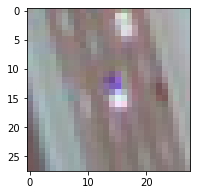

In [12]:
# Select random image from test
test_dir = 'input\\test'
img_files_test = [os.path.join(path, name) for path, subdirs, files in os.walk(test_dir) for name in files]
random_file = random.choice(img_files_test)

# Get the embedding for this image
emb = get_embedding(random_file, model=model)

print(random_file)
plt.rcParams["figure.figsize"] = (3,3)
image = mpimg.imread(random_file)
plt.imshow(image)
plt.show()

## Calculate Similarities Between the Selected Image and Train Images 

In [13]:
similarities = cosine_similarity(emb, train_emb)

## Preview K-Most Similar Images from Train Data 

input\train\schist\LFT67.jpg


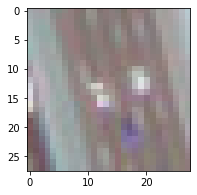

input\train\schist\BH2CR.jpg


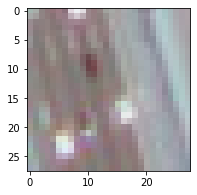

input\train\schist\CCH18.jpg


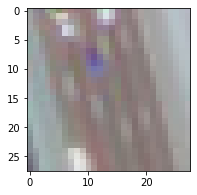

input\train\schist\EDA3C.jpg


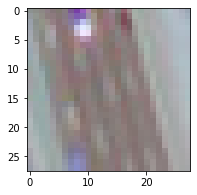

input\train\schist\TGUUP.jpg


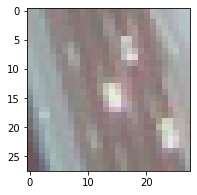

In [14]:
# Select top K-similar images
K=5
ids = np.flip(similarities.argsort()[0])[0:K+1]

for index in ids:
    image = img_files_train[index]
    print(image)
    image = mpimg.imread(image)
    plt.imshow(image)
    plt.show()